In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.colors as mcolors
import cmocean
import matplotlib.image as mpimg
from IPython.display import Image, display
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from modules.plotter import make_cmap
import matplotlib.gridspec as gridspec
%matplotlib inline

### Colorbars

In [2]:
## Lightning Frequency Colorbar ##
lightning_clevs2 = [0, 1, 10, 20, 40, 60,
         80, 100, 150, 200, 300, 400, 500, 700, 900]

cmap_data2 = [(255., 255., 255.),
             (104., 104., 200.),
             (200.,200.,224.),
             (32., 160.,32.),
             (112., 208., 112.),
             (176., 240., 176.),
             (224.,224.,0.),
             (232.,144.,8.),
             (200.,128.,32.),
             (192.,112.,48.),
             (208.,0.,0.),
             (160.,0.,0.),
             (56.,56.,56.),
             (168.,168.,168.)]
# cmap_data
myInt = 255.0
newCmap2 = []
for i in np.arange(len(cmap_data2)):
    newCmap2.append([x / myInt for x in cmap_data2[i]])
lightning_cmap2 = mcolors.ListedColormap(newCmap2, 'lightning2')
lightning_norm2 = mcolors.BoundaryNorm(lightning_clevs2, lightning_cmap2.N)

In [3]:
## Based on https://unidata.github.io/python-gallery/examples/Precipitation_Map.html
## Precipitation Color Bar from NWS chosen from https://www.keranews.org/post/national-weather-service-adds-new-colors-so-it-can-map-harveys-rains
clevs = [0, 0.1, 1., 2., 3., 6, 12, 25, 35, 40, 50, 65, 75, 100, 125]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(255.0, 255.0, 255.0),
             (199.0, 233.0, 192.0),
             (160.0, 216.0, 153.0),
             (116.0, 196.0, 118.0),
             (49.0, 163.0, 83.0),
             (0., 108.0, 43.),
             (255., 250., 138.),
             (255., 204., 78.),
             (253., 141., 60.),
             (252., 78., 42.),
             (219., 54., 56.),
             (173.0, 0., 38.),
             (112., 0., 38.),
             (63., 11., 53.),
             (106., 46., 138.)]

newCmap = []
for i in np.arange(len(cmap_data)):
    newCmap.append([x / myInt for x in cmap_data[i]])
cmap = mcolors.ListedColormap(newCmap, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

### Fig 1a - Lightning jpg

In [4]:
image=mpimg.imread('/home/sbarc/students/nash/repositories/arthunderstorm2019/figures/lightning_square.jpg')

# plt.axis("off")
# plt.imshow(image)
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticklabels([])
# cur_axes.axes.get_yaxis().set_ticklabels([])
# cur_axes.axes.get_xaxis().set_ticks([])
# cur_axes.axes.get_yaxis().set_ticks([])
# plt.show()

### Fig 1b Precip Accumulation and Hail Locations

In [5]:
## NOAA SWDI Hail Locations 6 March 2019 ##

## location and name of txt file
filename = '/home/sbarc/students/nash/data/NOAA_SWDI/swdiws_nx3hail_all_20190306_bbox_-131_31_-116_41.csv'
df = pd.read_csv(filename, header=0, parse_dates=['ZTIME'])
df = df.replace(-999, np.NaN)
x_hail = df.LON
y_hail = df.LAT
df['MAXSIZE'] = df['MAXSIZE']*25.4 ## convert from inches to mm
# df

print('Average hail size:', df.MAXSIZE.mean(), 'mm')
print('Max hail size:', df.MAXSIZE.max(), 'mm')

Average hail size: 13.548815566836103 mm
Max hail size: 44.449999999999996 mm


In [6]:
## Import GPM Precipitation Data

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(32,42), lon=slice(-125,-115))

filename_pattern =  '/home/sbarc/students/nash/data/GPM/imerg/3B*' 
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', concat_dim='time', group='Grid')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
# ds.info()

precip = ds.precipitationCal.transpose('time', 'lat', 'lon')
precip = precip.load()
precip_final = precip.sum('time')/2.0

## Santa Barbara Rain Information
SB_precip = precip.sel(lat=[34.4208], lon=[-119.6982], method='nearest')

# Total accumulated over SB
SB_precip_total = SB_precip.sum('time')/2.0
print('Total accumulated in SB:', SB_precip_total.values, 'mm')
# Max rain rate and time
SB_max = SB_precip.where(SB_precip==SB_precip.max(), drop=True).squeeze()
print('Max rain rate:', SB_max.values, 'mm/hour at', SB_max.time.values)

## Goleta Fire Station Rain Information
gfire_precip = precip.sel(lat=[34.25], lon=[-119.55], method='nearest')
# Total accumulated over SB
gfire_precip_total = gfire_precip.sum('time')/2.0
print('Total accumulated at Goleta Fire Station:', gfire_precip_total.values, 'mm')
# Max rain rate and time
gfire_max = gfire_precip.where(gfire_precip==gfire_precip.max(), drop=True).squeeze()
print('Max rain rate:', gfire_max.values, 'mm/hour at', gfire_max.time.values)

ds size in GB 30.23

Total accumulated in SB: [[77.66126]] mm
Max rain rate: 16.464298 mm/hour at 2019-03-06 04:30:00
Total accumulated at Goleta Fire Station: [[70.347786]] mm
Max rain rate: 13.966399 mm/hour at 2019-03-06 04:30:00


In [7]:
# Max rain accumulation
precip_max = precip_final.where(precip_final==precip_final.max(), drop=True).squeeze()
print('Max rain accumulation:', precip_max.values)

Max rain accumulation: 517.2565


(array([6.372554e+06, 8.648600e+04, 1.564900e+04, 3.465000e+03,
        1.194000e+03, 4.130000e+02, 1.570000e+02, 5.600000e+01,
        2.300000e+01, 3.000000e+00]),
 array([  0.      ,  51.725647, 103.451294, 155.17694 , 206.90259 ,
        258.62823 , 310.35388 , 362.07953 , 413.80518 , 465.53082 ,
        517.2565  ], dtype=float32),
 <a list of 10 Patch objects>)

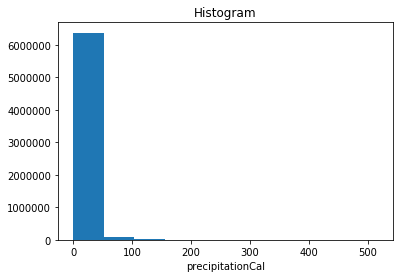

In [8]:
precip_final.plot.hist()

### Fig 1c - Lightning Strikes 6 March 2019

In [9]:
## Import Lightning Strike Data ##
filename = '/home/sbarc/students/nash/data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash20190306.csv'
df_lightning = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df_lightning
df_lightning['freq'] = df_lightning.icmultiplicity + df_lightning.cgmultiplicity

print('Total # of lightning flashes in 24 hours', df_lightning.freq.count())
print('Total # of CG pulses in 24 hours:', df_lightning.cgmultiplicity.sum())
print('Total # of IC pulses in 24 hours:', df_lightning.icmultiplicity.sum())
print('Total # of lightning pulses in 24 hours:', df_lightning.freq.sum())

Total # of lightning flashes in 24 hours 14416
Total # of CG pulses in 24 hours: 11536
Total # of IC pulses in 24 hours: 38863
Total # of lightning pulses in 24 hours: 50399


In [10]:
filename = '/home/sbarc/students/nash/data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash_combined.csv'
df_l1 = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df_l1['freq'] = df_l1.icmultiplicity + df_l1.cgmultiplicity

#greater than the start date and smaller than the end date
mask = (df_l1['timestamp'] >= '2019-03-05-12') & (df_l1['timestamp'] <= '2019-03-06-18')
lightning_event = df_l1.loc[mask]
print('Total # of lightning pulses in 30 hours of event:', lightning_event.freq.sum())
print('Total # of lightning flashes in 30 hours of event:', lightning_event.freq.count())

Total # of lightning pulses in 30 hours of event: 119363
Total # of lightning flashes in 30 hours of event: 73442


In [11]:
latitude_bins = np.arange(20.0, 50.1, 0.1)
longitude_bins = np.arange(-140.0, -109.9, 0.1)

latitude_group= pd.cut(df_lightning['latitude'], bins=latitude_bins)
longitude_group= pd.cut(df_lightning['longitude'], bins=longitude_bins)

new_df = df_lightning.groupby([(latitude_group), (longitude_group)]).sum()
lightning_count = new_df['freq'].values
lightning_count = lightning_count.reshape((latitude_bins.size-1, longitude_bins.size-1))

In [12]:
## Read all data into single xarray dataset 
ds_lightning = xr.Dataset({'freq': (['lat', 'lon'], lightning_count)},
                coords={'lat': (['lat'], latitude_bins[:-1]),
                        'lon': (['lon'], longitude_bins[:-1])})


## Find location of maximum count
da_max_freq = ds_lightning.freq.where(ds_lightning.freq==ds_lightning.freq.max(), drop=True).squeeze()
da_max_freq

<xarray.DataArray 'freq' ()>
array(933.)
Coordinates:
    lat      float64 37.6
    lon      float64 -120.6

### Fig 1d - Lightning Climatology with Lightning points 4 - 5 UTC

In [13]:
## Import Lightning Climatology Data ##
filename = '/home/sbarc/students/nash/data/TRMM_LIS-OTD/LISOTD_HRFC_V2.3.2015.nc'
# filename = '/home/sbarc/students/nash/data/TRMM_LIS-OTD/LISOTD_LRFC_V2.3.2015.nc'
lightning_clim_ds = xr.open_dataset(filename, decode_times=False)
lightning_clim = lightning_clim_ds.HRFC_COM_FR
# lightning_clim = lightning_clim_ds.LRFC_COM_FR

clim_area = lightning_clim_ds.HRFC_AREA ## area of each grid cell km^2
# clim_area = lightning_clim_ds.LRFC_AREA ## area of each grid cell km^2

lightning_clim_new = (lightning_clim * clim_area)/365.25 ## convert to count/day
lightning_clim_new.attrs['units'] = 'count/day'

print('Average Flash Density', lightning_clim.sel(Latitude=slice(30, 40), Longitude=slice(-125.0, -115.0)).mean().values,
     lightning_clim.units)

print('Average Flash Density', lightning_clim_new.sel(Latitude=slice(30, 40), Longitude=slice(-125.0, -115.0)).mean().values,
     lightning_clim_new.units)

print('Average Flash Density', lightning_clim.sel(Latitude=slice(20, 50), Longitude=slice(-140.0, -110.0)).mean().values,
     lightning_clim.units)

print('Average Flash Density', lightning_clim_new.sel(Latitude=slice(20, 50), Longitude=slice(-140.0, -110.0)).mean().values,
     lightning_clim_new.units)

Average Flash Density 0.83821106 count/km^2/year
Average Flash Density 5.7209134 count/day
Average Flash Density 1.3736199 count/km^2/year
Average Flash Density 9.145082 count/day


In [14]:
#greater than the start date and smaller than the end date
mask = (df_lightning['timestamp'] > '2019-03-06-04') & (df_lightning['timestamp'] <= '2019-03-06-05')
lightning_6mar19_4UTC = df_lightning.loc[mask]

print('Max Lat:', lightning_6mar19_4UTC.latitude.max())
print('Min Lat:', lightning_6mar19_4UTC.latitude.min())
print('Max Lon:', lightning_6mar19_4UTC.longitude.max())
print('Min Lon:', lightning_6mar19_4UTC.longitude.min())

Max Lat: 36.01961
Min Lat: 30.98787
Max Lon: -117.77003
Min Lon: -123.38706


### Figure 1 Final

./figures/f1.png


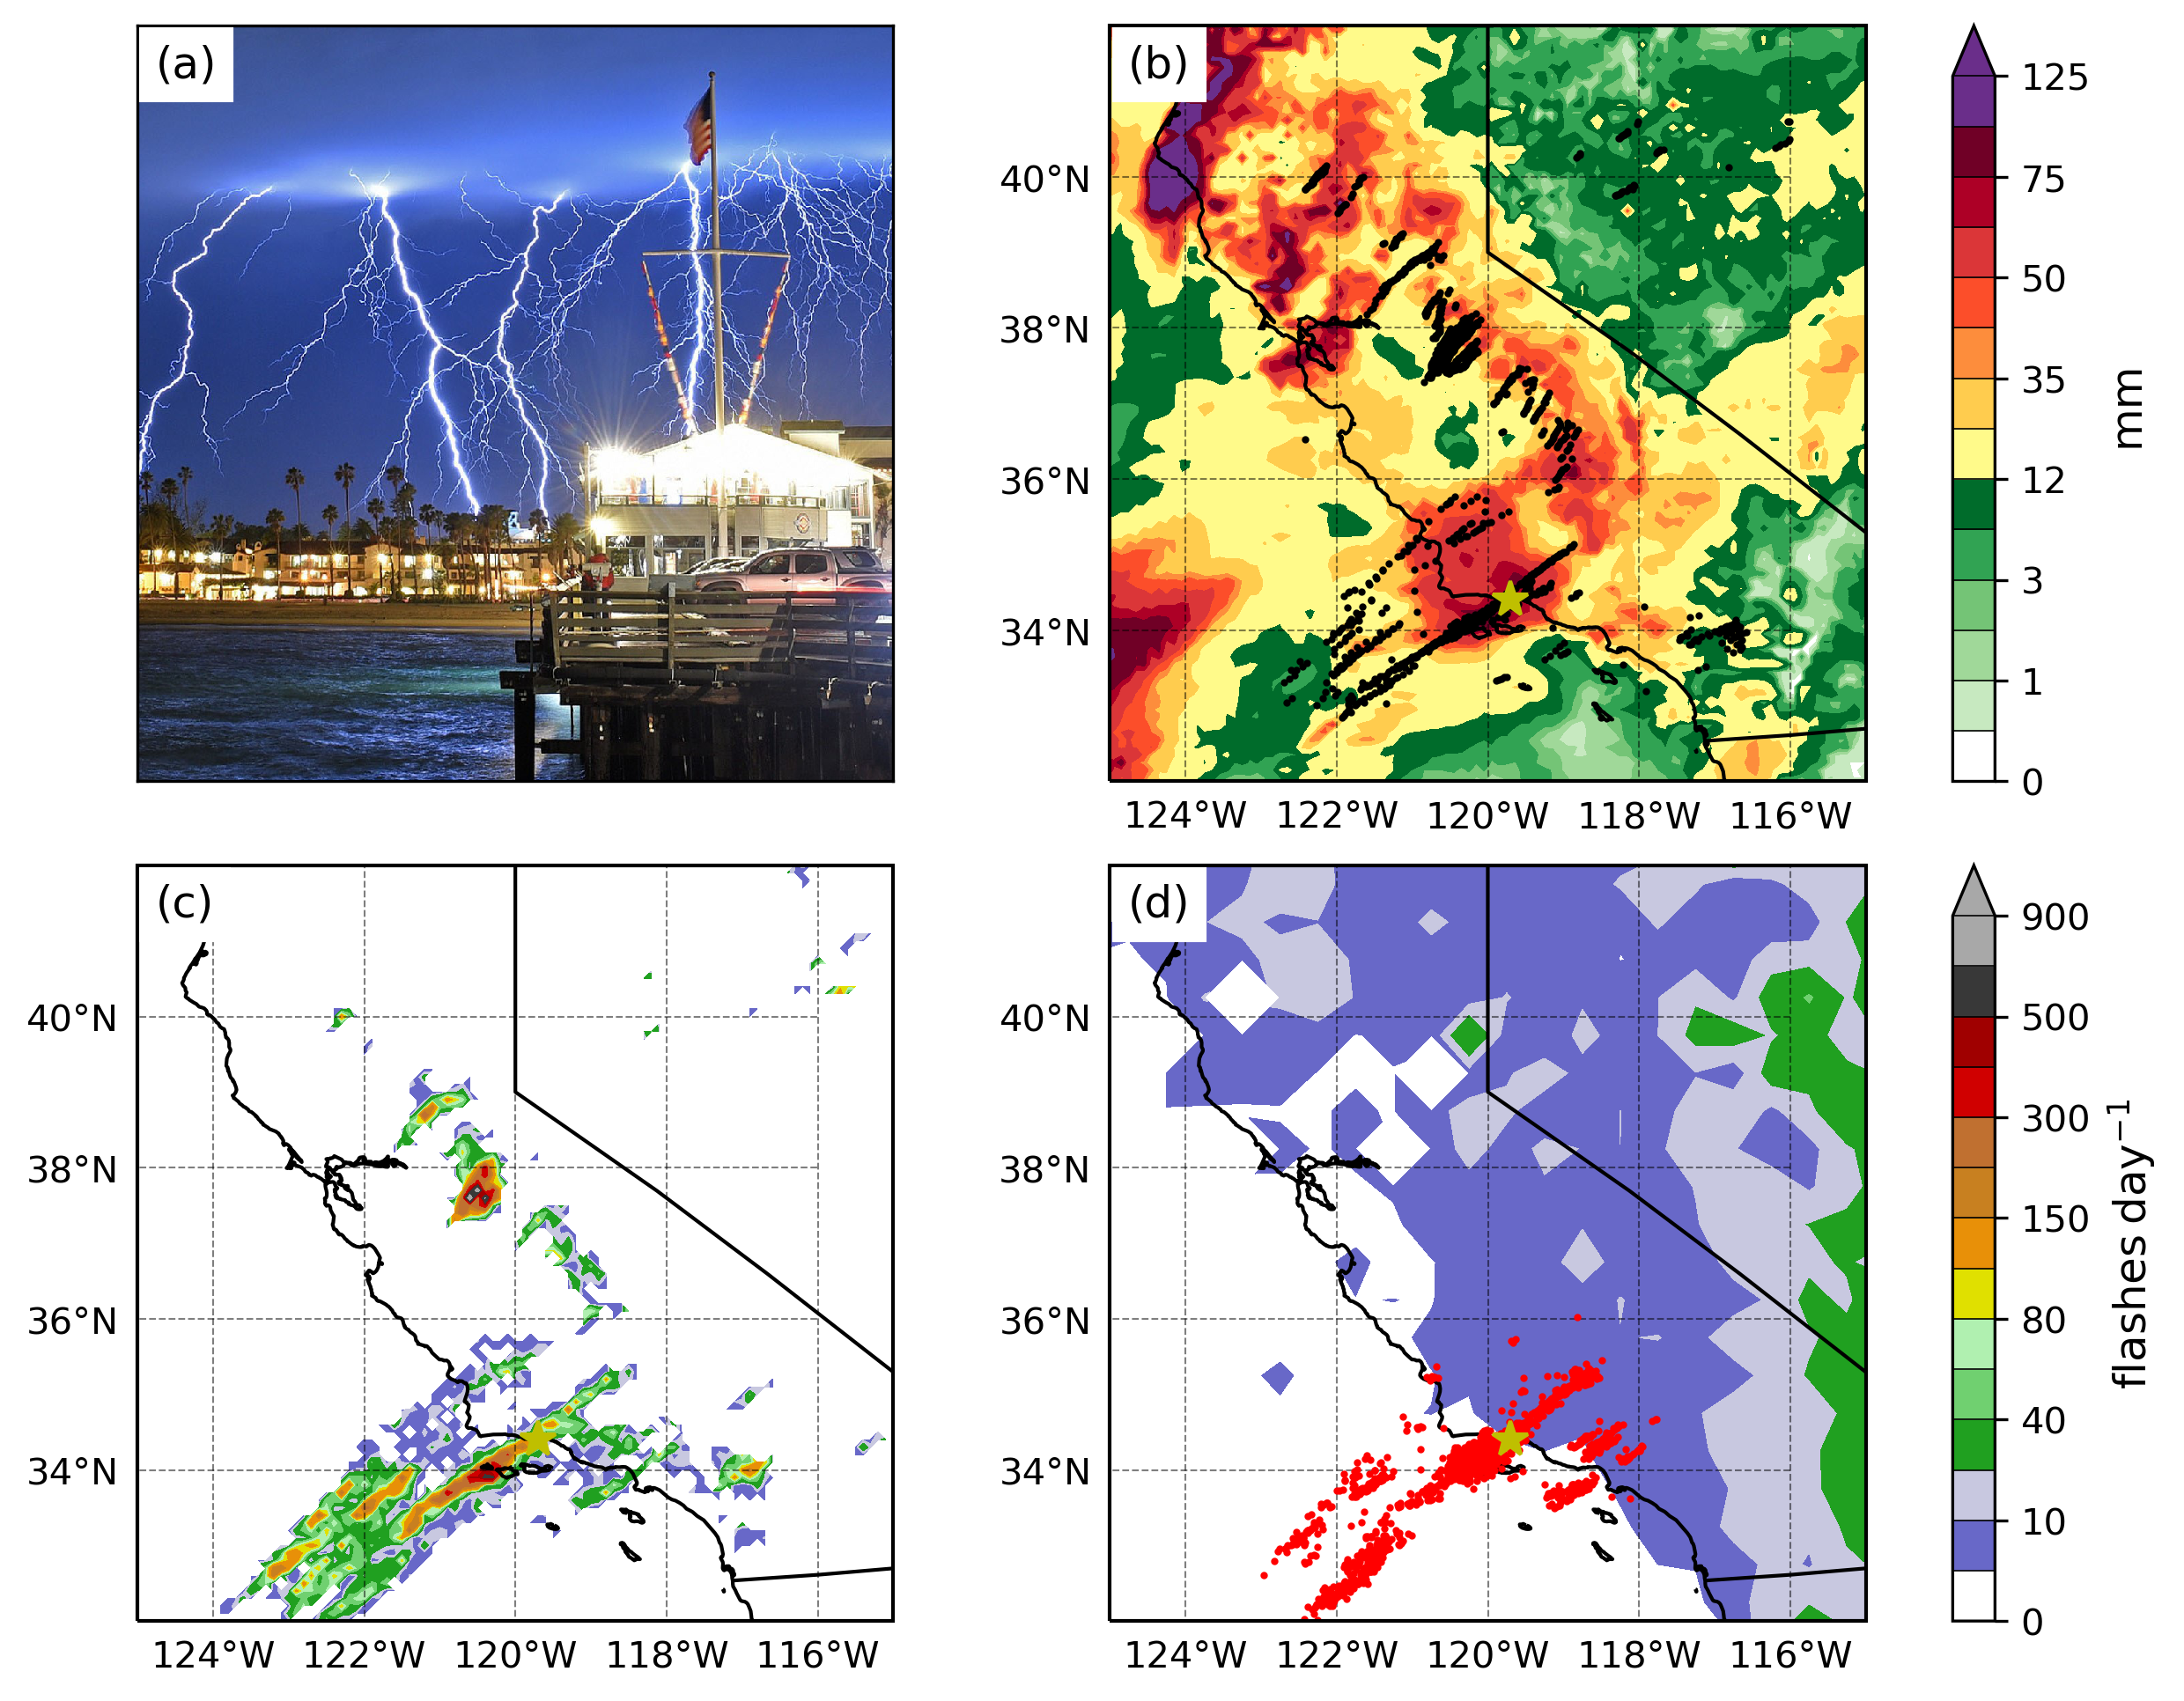

<Figure size 2400x2400 with 0 Axes>

In [15]:
## All plots together
## figsize=(width,height (inches))
fig = plt.figure(figsize=(8.,8.))
fig.dpi = 300
fname = './figures/f1'
fmt1 = 'png'
fmt2 = 'pdf'

## Map Information
# ext = (-118.5, -121.0, 33.5, 35.5) ## zoomed in to SB
# ext = (-117.5, -123.5, 30.0, 36.0) ## central coast
ext = (-115.0, -125.0, 32.0, 42.0)
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()

## Figure Grid
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
## gs[rows index, columns index]
# gs = gridspec.GridSpec(numrows, numcols, hspace=0.2, wspace=0.1)
gs = fig.add_gridspec(nrows=4, ncols=4, hspace=0.25, wspace=0.001, left=0.05, right=0.97)
gs1 = fig.add_gridspec(nrows=4, ncols=1, hspace=0.25, wspace=0.01, left=0.96, right=0.98)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# ## Colormap information
# lightning_cmap2 = cmocean.cm.thermal_r
# lightning_clevs2 = [1, 5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 400]
# lightning_norm2 = mcolors.BoundaryNorm(lightning_clevs2, lightning_cmap2.N)

# cmap = cmocean.cm.deep
# clevs = [0.1, 6, 12, 25, 35, 45, 55, 65, 75, 100, 125]
# norm = mcolors.BoundaryNorm(clevs, cmap.N)

################################
# Plot Fig1a - lightning image #
################################

ax3 = fig.add_subplot(gs[:2, :2])
# ax3.axis("off")
ax3.imshow(image)
cur_axes = plt.gca()
ax3.get_xaxis().set_ticklabels([])
ax3.get_yaxis().set_ticklabels([])
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
# plt.title('(c)', fontsize=12, loc='left')
plt.annotate('(a)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')


#######################################################
# Plot Fig1b - Precip Accumulation and Hail Locations #
#######################################################

ax4 = fig.add_subplot(gs[:2, 2:], projection=datacrs)
ax4.set_extent(ext, crs=datacrs)

cf = ax4.contourf(precip_final.lon, precip_final.lat, precip_final, transform=datacrs, 
                 cmap=cmap, norm=norm, levels=clevs, extend='max')

ax4.plot(x_hail, y_hail, 'ko', markersize=1, transform=ccrs.PlateCarree())


gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -114., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot Santa Barbara Star
ax4.plot(-119.7, 34.4, 'y*', markersize=10, transform=mapcrs)

# Add Border Features
ax4.coastlines(linewidths=1.0, resolution='10m')
ax4.add_feature(states_provinces, edgecolor='k')
ax4.add_feature(cfeature.BORDERS)

# plt.title('(d)', fontsize=12, loc='left')
plt.annotate('(b)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')

########################
# Plot Precip Colorbar #
########################
# Add color bar
cax2 = fig.add_subplot(gs1[:2, :])
cbar = fig.colorbar(cf, cax=cax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto', shrink=0.8)
cbar.ax.set_ylabel('mm', fontsize=12)


################################################
# Plot Fig1c -  Lightning Strikes 6 March 2019 #
################################################

ax2 = fig.add_subplot(gs[2:, :2], projection=datacrs)
ax2.set_extent(ext, crs=datacrs)

cf = ax2.contourf(longitude_bins[:-1], latitude_bins[:-1], 
                 lightning_count, transform=mapcrs, extend='max',
                 cmap=lightning_cmap2, norm=lightning_norm2, levels=lightning_clevs2)

gl = ax2.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -114., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot Santa Barbara Star
ax2.plot(-119.7, 34.4, 'y*', markersize=10, transform=mapcrs)

# Add Border Features
ax2.coastlines(linewidths=1.0, resolution='10m')
ax2.add_feature(states_provinces, edgecolor='k')
ax2.add_feature(cfeature.BORDERS)

# plt.title('(b)', fontsize=12, loc='left')
plt.annotate('(c)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')


#######################################################################
# Plot Fig1d -  Lightning Climatology with Lightning points 4 - 5 UTC #
#######################################################################

ax1 = fig.add_subplot(gs[2:, 2:], projection=datacrs)
ax1.set_extent(ext, crs=datacrs)

## Plot Lightning Strike Locations for 6 March 2019 4-5 UTC ##
ax1.plot(lightning_6mar19_4UTC.longitude, lightning_6mar19_4UTC.latitude,
        'ro', markersize=1, transform=mapcrs)

## Filled Contour Plot of Lightning Clim ##
cf = ax1.contourf(lightning_clim_new.Longitude, lightning_clim_new.Latitude, lightning_clim_new,
                 transform=mapcrs, extend='max', 
                 cmap=lightning_cmap2, norm=lightning_norm2, levels=lightning_clevs2)

# cbar = fig.colorbar(cf, ax=ax1, extend='neither', orientation='vertical')
# cbar.ax.set_ylabel('$\mathrm{flashes \: day^{-1}}$', fontsize=12)

# Plot Santa Barbara Star
ax1.plot(-119.7, 34.4, 'y*', markersize=10, transform=mapcrs)

# Add Border Features
ax1.coastlines(linewidths=1.0, resolution='10m')
ax1.add_feature(states_provinces, edgecolor='k')
ax1.add_feature(cfeature.BORDERS)

gl = ax1.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -114., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# plt.title('(a)', fontsize=12, loc='left')
plt.annotate('(d)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')


###########################
# Plot Lightning Colorbar #
###########################
cax1 = fig.add_subplot(gs1[2:, :])
cbar = fig.colorbar(cf, cax=cax1, drawedges=True, 
                    orientation='vertical', extendfrac='auto', shrink=0.8)
cbar.ax.set_ylabel('$\mathrm{flashes \: day^{-1}}$', fontsize=12)


###################
# Finalize Figure # 
###################
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))